In [3]:
import sys
sys.path.append("..")
import feature_engineer as fe
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

In [4]:
with open('../data/dataset_df.pkl', 'rb') as file:
    dataset_df = pickle.load(file)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


In [5]:
with open('../data/labels.pkl', 'rb') as file:
    labels = pickle.load(file)
print("Full train label shape is {}".format(labels.shape))

Full train label shape is (424116, 4)


In [6]:
dataset_df = fe.feature_engineer2(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (70686, 58)


In [7]:
FEATURES = [c for c in dataset_df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = dataset_df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 57 features
We will train with 23562 users info


In [8]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

for i, (train_index, test_index) in enumerate(gkf.split(X=dataset_df, groups=dataset_df.index)):
    print('### Fold',i+1)
    
    for t in range(1,19):
        print(t,', ',end='')
        
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        train_x = dataset_df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels.q==t].set_index('session').loc[train_users]
        
        valid_x = dataset_df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels.q==t].set_index('session').loc[valid_users]

        train_x["correct"] = train_y["correct"]
        valid_x["correct"] = valid_y["correct"]

        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_x.loc[:, train_x.columns != 'level_group'], label="correct")
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_x.loc[:, valid_x.columns != 'level_group'], label="correct")
        
        clf = tfdf.keras.GradientBoostedTreesModel(verbose=0) 
        clf.compile(metrics=["accuracy"])
        clf.fit(x=train_ds)
        models[f'{grp}_{t}'] = clf

        oof.loc[valid_users, t-1] = clf.predict(x=valid_ds).flatten()

### Fold 1
1 , 

2023-07-29 20:37:48.838561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-29 20:37:48.839253: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[WARNING 23-07-29 20:37:48.9481 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:37:48.9482 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:37:48.9482 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set bu

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 20ms/step
2 , 

[WARNING 23-07-29 20:37:58.0041 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:37:58.0041 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:37:58.0041 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:00.4995 AEST kernel.cc:1243] Loading model from path /tmp/tmp5bj1ogqr/model/ with prefix 944753503fac4905
[INFO 23-07-29 20:38:00.5007 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 19ms/step
3 , 

[WARNING 23-07-29 20:38:01.3179 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:01.3180 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:01.3180 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:04.1134 AEST kernel.cc:1243] Loading model from path /tmp/tmpyqqdkt1k/model/ with prefix be25bf7c7c264344
[INFO 23-07-29 20:38:04.1158 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
4 , 

[WARNING 23-07-29 20:38:04.8420 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:04.8421 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:04.8421 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:09.3738 AEST kernel.cc:1243] Loading model from path /tmp/tmpro0i4obh/model/ with prefix e79dcb6a210547e6
[INFO 23-07-29 20:38:09.3779 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:38:09.3779 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
5 , 

[WARNING 23-07-29 20:38:10.1280 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:10.1280 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:10.1280 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


[INFO 23-07-29 20:38:12.5989 AEST kernel.cc:1243] Loading model from path /tmp/tmpxv1o852g/model/ with prefix 134fba79a9594507
[INFO 23-07-29 20:38:12.6003 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
6 , 

[WARNING 23-07-29 20:38:13.3306 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:13.3306 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:13.3306 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


[INFO 23-07-29 20:38:16.7863 AEST kernel.cc:1243] Loading model from path /tmp/tmp8foq44dw/model/ with prefix d59241cea8a547da
[INFO 23-07-29 20:38:16.7885 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
7 , 

[WARNING 23-07-29 20:38:17.5405 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:17.5405 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:17.5405 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:20.0469 AEST kernel.cc:1243] Loading model from path /tmp/tmpskte5si4/model/ with prefix e5921f8021564a1b
[INFO 23-07-29 20:38:20.0484 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:38:20.0485 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 21ms/step
8 , 

[WARNING 23-07-29 20:38:20.9438 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:20.9438 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:20.9438 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:23.4627 AEST kernel.cc:1243] Loading model from path /tmp/tmp8fcp6rvy/model/ with prefix df7276a164e54531
[INFO 23-07-29 20:38:23.4648 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
9 , 

[WARNING 23-07-29 20:38:24.1994 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:24.1994 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:24.1994 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:26.7657 AEST kernel.cc:1243] Loading model from path /tmp/tmpgqi7t5at/model/ with prefix 890ac6085b0c468b
[INFO 23-07-29 20:38:26.7676 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
10 , 

[WARNING 23-07-29 20:38:27.4795 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:27.4795 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:27.4795 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:30.0625 AEST kernel.cc:1243] Loading model from path /tmp/tmpg26n91u5/model/ with prefix eb3669b344ad4595
[INFO 23-07-29 20:38:30.0641 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:38:30.0641 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
11 , 

[WARNING 23-07-29 20:38:30.8392 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:30.8392 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:30.8392 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:33.6405 AEST kernel.cc:1243] Loading model from path /tmp/tmpmc_4ue9d/model/ with prefix 12049a70345e4d2b
[INFO 23-07-29 20:38:33.6422 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
12 , 

[WARNING 23-07-29 20:38:34.3466 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:34.3466 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:34.3466 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:36.8183 AEST kernel.cc:1243] Loading model from path /tmp/tmpsyhh7385/model/ with prefix 90f73f3e5d554439
[INFO 23-07-29 20:38:36.8198 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
13 , 

[WARNING 23-07-29 20:38:37.5753 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:37.5753 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:37.5753 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:40.7888 AEST kernel.cc:1243] Loading model from path /tmp/tmp6xcvcjat/model/ with prefix 40d8762152874e35
[INFO 23-07-29 20:38:40.7909 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:38:40.7909 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 19ms/step
14 , 

[WARNING 23-07-29 20:38:41.5341 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:41.5341 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:41.5341 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:44.2588 AEST kernel.cc:1243] Loading model from path /tmp/tmpcsgyjbho/model/ with prefix 6783bf49bea04d0b
[INFO 23-07-29 20:38:44.2604 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
15 , 

[WARNING 23-07-29 20:38:44.9566 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:44.9566 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:44.9566 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:49.3883 AEST kernel.cc:1243] Loading model from path /tmp/tmp93hisysc/model/ with prefix 79f78aed17754266
[INFO 23-07-29 20:38:49.3930 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
16 , 

[WARNING 23-07-29 20:38:50.1184 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:50.1185 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:50.1185 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:52.5791 AEST kernel.cc:1243] Loading model from path /tmp/tmpghcy6qzj/model/ with prefix 99c2f5d198bb419f
[INFO 23-07-29 20:38:52.5805 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:38:52.5805 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
17 , 

[WARNING 23-07-29 20:38:53.2616 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:53.2616 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:53.2616 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:55.1788 AEST kernel.cc:1243] Loading model from path /tmp/tmpb60tej6f/model/ with prefix bbc767b3bd454eba
[INFO 23-07-29 20:38:55.1796 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
18 , 

[WARNING 23-07-29 20:38:55.8858 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:55.8858 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:55.8858 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:38:58.5590 AEST kernel.cc:1243] Loading model from path /tmp/tmpf6z9vxrn/model/ with prefix 350477c1342b4977
[INFO 23-07-29 20:38:58.5606 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
### Fold 2
1 , 

[WARNING 23-07-29 20:38:59.2404 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:59.2404 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:38:59.2404 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:03.5675 AEST kernel.cc:1243] Loading model from path /tmp/tmpxan9ouqt/model/ with prefix 31ad3730620e4ba0
[INFO 23-07-29 20:39:03.5718 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:39:03.5718 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
2 , 

[WARNING 23-07-29 20:39:04.3478 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:04.3478 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:04.3478 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:06.2486 AEST kernel.cc:1243] Loading model from path /tmp/tmprifmf56c/model/ with prefix bf2315d5f802445b
[INFO 23-07-29 20:39:06.2493 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
3 , 

[WARNING 23-07-29 20:39:06.9474 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:06.9474 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:06.9474 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:09.5730 AEST kernel.cc:1243] Loading model from path /tmp/tmpne0r0g9s/model/ with prefix bda8c639ea254136
[INFO 23-07-29 20:39:09.5747 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
4 , 

[WARNING 23-07-29 20:39:10.2833 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:10.2833 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:10.2833 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:13.8992 AEST kernel.cc:1243] Loading model from path /tmp/tmpecmrif6g/model/ with prefix c054fca05ac34305
[INFO 23-07-29 20:39:13.9022 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:39:13.9023 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
5 , 

[WARNING 23-07-29 20:39:14.7624 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:14.7624 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:14.7624 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:17.8788 AEST kernel.cc:1243] Loading model from path /tmp/tmp05m8gnju/model/ with prefix 5178ebd1f118427b
[INFO 23-07-29 20:39:17.8810 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
6 , 

[WARNING 23-07-29 20:39:18.9267 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:18.9267 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:18.9267 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:21.6783 AEST kernel.cc:1243] Loading model from path /tmp/tmpvyx9eh0c/model/ with prefix f0327c2a457546cb
[INFO 23-07-29 20:39:21.6803 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
7 , 

[WARNING 23-07-29 20:39:22.4750 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:22.4750 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:22.4750 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:24.8438 AEST kernel.cc:1243] Loading model from path /tmp/tmpjc4pkbjc/model/ with prefix a77211b6ab7a4a83
[INFO 23-07-29 20:39:24.8455 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:39:24.8455 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 19ms/step
8 , 

[WARNING 23-07-29 20:39:25.6745 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:25.6745 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:25.6745 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:28.1330 AEST kernel.cc:1243] Loading model from path /tmp/tmpfy8p4a0g/model/ with prefix e4469ce9e6f242a5
[INFO 23-07-29 20:39:28.1342 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
9 , 

[WARNING 23-07-29 20:39:28.8558 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:28.8558 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:28.8558 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:31.3378 AEST kernel.cc:1243] Loading model from path /tmp/tmpgoby44ec/model/ with prefix ec74125aebe04e34
[INFO 23-07-29 20:39:31.3394 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
10 , 

[WARNING 23-07-29 20:39:32.0853 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:32.0853 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:32.0854 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:34.8200 AEST kernel.cc:1243] Loading model from path /tmp/tmp8curd5x4/model/ with prefix e9c75b02da0349dc
[INFO 23-07-29 20:39:34.8217 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
11 , 

[WARNING 23-07-29 20:39:35.5413 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:35.5413 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:35.5413 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:38.6161 AEST kernel.cc:1243] Loading model from path /tmp/tmpom0a2eyj/model/ with prefix add0f6517e3e4dc9
[INFO 23-07-29 20:39:38.6180 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:39:38.6181 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
12 , 

[WARNING 23-07-29 20:39:39.4088 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:39.4088 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:39.4088 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:41.9691 AEST kernel.cc:1243] Loading model from path /tmp/tmpgtq7xxa0/model/ with prefix 5a7a284fe8804a91
[INFO 23-07-29 20:39:41.9706 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 20ms/step
13 , 

[WARNING 23-07-29 20:39:42.8017 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:42.8017 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:42.8017 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:45.7145 AEST kernel.cc:1243] Loading model from path /tmp/tmp_969zu_n/model/ with prefix ac3debac50c54378
[INFO 23-07-29 20:39:45.7163 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
14 , 

[WARNING 23-07-29 20:39:46.4388 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:46.4389 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:46.4389 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:49.8212 AEST kernel.cc:1243] Loading model from path /tmp/tmpezwu5gqt/model/ with prefix e21dd071ac6340b4
[INFO 23-07-29 20:39:49.8241 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:39:49.8241 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
15 , 

[WARNING 23-07-29 20:39:50.6810 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:50.6811 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:50.6811 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:53.6007 AEST kernel.cc:1243] Loading model from path /tmp/tmptt92cuy1/model/ with prefix 3102760d1f8e495c
[INFO 23-07-29 20:39:53.6027 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 20ms/step
16 , 

[WARNING 23-07-29 20:39:54.9544 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:54.9545 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:54.9545 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:39:57.3122 AEST kernel.cc:1243] Loading model from path /tmp/tmpnbnfwhdc/model/ with prefix 5119d5b82c39447c
[INFO 23-07-29 20:39:57.3133 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
17 , 

[WARNING 23-07-29 20:39:58.0940 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:58.0940 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:39:58.0940 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:00.2459 AEST kernel.cc:1243] Loading model from path /tmp/tmpu2ooz5k9/model/ with prefix 485478f7b37846ed
[INFO 23-07-29 20:40:00.2469 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:40:00.2469 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 21ms/step
18 , 

[WARNING 23-07-29 20:40:01.1261 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:01.1261 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:01.1262 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:03.5666 AEST kernel.cc:1243] Loading model from path /tmp/tmpzav3ftoq/model/ with prefix fd1f56248d1d4877
[INFO 23-07-29 20:40:03.5681 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
### Fold 3
1 , 

[WARNING 23-07-29 20:40:04.3417 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:04.3417 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:04.3417 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:09.0901 AEST kernel.cc:1243] Loading model from path /tmp/tmpwzk9r97m/model/ with prefix 7c93c00270b44124
[INFO 23-07-29 20:40:09.0949 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
2 , 

[WARNING 23-07-29 20:40:09.9290 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:09.9290 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:09.9291 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:12.5662 AEST kernel.cc:1243] Loading model from path /tmp/tmpc9s66d7q/model/ with prefix dcb31e9799db4714
[INFO 23-07-29 20:40:12.5675 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:40:12.5676 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
3 , 

[WARNING 23-07-29 20:40:13.3368 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:13.3368 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:13.3368 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:19.2621 AEST kernel.cc:1243] Loading model from path /tmp/tmp93kaeun_/model/ with prefix 05ada984078e4a36
[INFO 23-07-29 20:40:19.2688 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
4 , 

[WARNING 23-07-29 20:40:24.3759 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:24.3760 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:24.3760 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:28.0367 AEST kernel.cc:1243] Loading model from path /tmp/tmppi7dtf_r/model/ with prefix 12b443e0defd4843
[INFO 23-07-29 20:40:28.0397 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:40:28.0397 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
5 , 

[WARNING 23-07-29 20:40:28.7574 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:28.7574 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:28.7574 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:30.9512 AEST kernel.cc:1243] Loading model from path /tmp/tmpwl8ixb61/model/ with prefix 1d435d044c554460
[INFO 23-07-29 20:40:30.9522 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
6 , 

[WARNING 23-07-29 20:40:31.6694 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:31.6694 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:31.6694 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:34.1318 AEST kernel.cc:1243] Loading model from path /tmp/tmpun2rrteh/model/ with prefix a7a20a2ff6fc4d2e
[INFO 23-07-29 20:40:34.1333 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
7 , 

[WARNING 23-07-29 20:40:34.8691 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:34.8691 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:34.8691 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:37.5750 AEST kernel.cc:1243] Loading model from path /tmp/tmpsdh8yxw4/model/ with prefix 5b015d8c95174b8d
[INFO 23-07-29 20:40:37.5764 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
8 , 

[WARNING 23-07-29 20:40:38.2889 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:38.2889 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:38.2889 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:41.4925 AEST kernel.cc:1243] Loading model from path /tmp/tmp0yhghj7v/model/ with prefix 3c5d701bc2e24cdc
[INFO 23-07-29 20:40:41.4951 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:40:41.4951 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
9 , 

[WARNING 23-07-29 20:40:42.2834 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:42.2834 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:42.2834 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:45.2842 AEST kernel.cc:1243] Loading model from path /tmp/tmpl23ymy67/model/ with prefix 74df190955f54529
[INFO 23-07-29 20:40:45.2858 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
10 , 

[WARNING 23-07-29 20:40:46.6533 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:46.6533 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:46.6533 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:49.0540 AEST kernel.cc:1243] Loading model from path /tmp/tmp_saqgxy6/model/ with prefix b7059f34a1f247ff
[INFO 23-07-29 20:40:49.0553 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
11 , 

[WARNING 23-07-29 20:40:49.9020 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:49.9020 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:49.9020 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:53.4061 AEST kernel.cc:1243] Loading model from path /tmp/tmpd0gx4db0/model/ with prefix 2a04dd4425904c93
[INFO 23-07-29 20:40:53.4093 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:40:53.4094 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
12 , 

[WARNING 23-07-29 20:40:54.1581 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:54.1581 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:54.1581 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:40:57.0066 AEST kernel.cc:1243] Loading model from path /tmp/tmpevp6r1wb/model/ with prefix bfd00c6c75c04e75
[INFO 23-07-29 20:40:57.0082 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
13 , 

[WARNING 23-07-29 20:40:57.7324 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:57.7324 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:40:57.7324 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:00.0121 AEST kernel.cc:1243] Loading model from path /tmp/tmpadywl8s8/model/ with prefix db6680becee242c8
[INFO 23-07-29 20:41:00.0134 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
14 , 

[WARNING 23-07-29 20:41:00.7255 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:00.7255 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:00.7255 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:03.5727 AEST kernel.cc:1243] Loading model from path /tmp/tmp67ej81nh/model/ with prefix 1339c0a096fe4c86
[INFO 23-07-29 20:41:03.5746 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:41:03.5746 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
15 , 

[WARNING 23-07-29 20:41:04.3154 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:04.3154 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:04.3154 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:07.8785 AEST kernel.cc:1243] Loading model from path /tmp/tmp528ebyr9/model/ with prefix d757362ebea648f5
[INFO 23-07-29 20:41:07.8815 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 19ms/step
16 , 

[WARNING 23-07-29 20:41:08.6336 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:08.6336 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:08.6336 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:10.8119 AEST kernel.cc:1243] Loading model from path /tmp/tmp56bdbv_y/model/ with prefix 02fe35414fbf4ca4
[INFO 23-07-29 20:41:10.8126 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
17 , 

[WARNING 23-07-29 20:41:11.5330 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:11.5330 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:11.5330 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:13.5067 AEST kernel.cc:1243] Loading model from path /tmp/tmpr6a3p79y/model/ with prefix 23ac7f8faa7541b3
[INFO 23-07-29 20:41:13.5074 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
18 , 

[WARNING 23-07-29 20:41:14.2726 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:14.2726 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:14.2726 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:17.2062 AEST kernel.cc:1243] Loading model from path /tmp/tmpkkd40vi7/model/ with prefix 35bc333d363e4d41
[INFO 23-07-29 20:41:17.2077 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:41:17.2077 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
### Fold 4
1 , 

[WARNING 23-07-29 20:41:17.9306 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:17.9306 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:17.9306 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:23.0007 AEST kernel.cc:1243] Loading model from path /tmp/tmpyv9v7atc/model/ with prefix 59a75ea8028d49d8
[INFO 23-07-29 20:41:23.0058 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
2 , 

[WARNING 23-07-29 20:41:23.7467 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:23.7467 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:23.7467 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:26.9984 AEST kernel.cc:1243] Loading model from path /tmp/tmpjjs4fi6s/model/ with prefix db48f518e728461e
[INFO 23-07-29 20:41:27.0010 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 19ms/step
3 , 

[WARNING 23-07-29 20:41:27.8282 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:27.8282 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:27.8282 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:30.4139 AEST kernel.cc:1243] Loading model from path /tmp/tmpcqhebm8h/model/ with prefix cb7fa2b78db545e2
[INFO 23-07-29 20:41:30.4152 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:41:30.4153 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
4 , 

[WARNING 23-07-29 20:41:31.6867 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:31.6867 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:31.6867 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:35.3295 AEST kernel.cc:1243] Loading model from path /tmp/tmpo1qywupm/model/ with prefix 9c048ec9cd414935
[INFO 23-07-29 20:41:35.3324 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 19ms/step
5 , 

[WARNING 23-07-29 20:41:36.1526 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:36.1527 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:36.1527 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:39.1324 AEST kernel.cc:1243] Loading model from path /tmp/tmponmplyut/model/ with prefix e8ab8e2f803d4f4c
[INFO 23-07-29 20:41:39.1347 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
6 , 

[WARNING 23-07-29 20:41:39.9613 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:39.9613 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:39.9613 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:42.7810 AEST kernel.cc:1243] Loading model from path /tmp/tmpc6lb81em/model/ with prefix 64aba08eb9124a08
[INFO 23-07-29 20:41:42.7828 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:41:42.7828 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
7 , 

[WARNING 23-07-29 20:41:43.5634 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:43.5634 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:43.5634 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:47.0177 AEST kernel.cc:1243] Loading model from path /tmp/tmpkn2doqww/model/ with prefix 133fb8a1ab874a6b
[INFO 23-07-29 20:41:47.0204 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
8 , 

[WARNING 23-07-29 20:41:47.7349 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:47.7349 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:47.7349 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:50.5614 AEST kernel.cc:1243] Loading model from path /tmp/tmpu7txndh8/model/ with prefix 4cfdbc840f234ef0
[INFO 23-07-29 20:41:50.5631 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
9 , 

[WARNING 23-07-29 20:41:51.3036 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:51.3036 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:51.3037 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:41:56.7818 AEST kernel.cc:1243] Loading model from path /tmp/tmp0lsjsxn2/model/ with prefix f8d469da973a4991
[INFO 23-07-29 20:41:56.7866 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:41:56.7866 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 20ms/step
10 , 

[WARNING 23-07-29 20:41:57.5909 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:57.5910 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:41:57.5910 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:00.9843 AEST kernel.cc:1243] Loading model from path /tmp/tmpqv1n2vod/model/ with prefix 418c300ab9104378
[INFO 23-07-29 20:42:00.9885 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
11 , 

[WARNING 23-07-29 20:42:01.7053 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:01.7053 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:01.7053 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:04.6111 AEST kernel.cc:1243] Loading model from path /tmp/tmpi4tt3mhh/model/ with prefix ee960829bff8466b
[INFO 23-07-29 20:42:04.6132 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
12 , 

[WARNING 23-07-29 20:42:05.3318 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:05.3318 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:05.3318 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:07.6194 AEST kernel.cc:1243] Loading model from path /tmp/tmp2k8lfd0p/model/ with prefix 881029a830f84d24
[INFO 23-07-29 20:42:07.6205 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:42:07.6205 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
13 , 

[WARNING 23-07-29 20:42:08.3201 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:08.3201 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:08.3201 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:10.3539 AEST kernel.cc:1243] Loading model from path /tmp/tmpr7val0_8/model/ with prefix d2e99d3ef157458f
[INFO 23-07-29 20:42:10.3548 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
14 , 

[WARNING 23-07-29 20:42:11.0474 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:11.0474 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:11.0474 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:15.3037 AEST kernel.cc:1243] Loading model from path /tmp/tmp912txw1d/model/ with prefix 6254e01bd4bc4d32
[INFO 23-07-29 20:42:15.3074 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
15 , 

[WARNING 23-07-29 20:42:16.0586 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:16.0586 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:16.0586 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:18.9413 AEST kernel.cc:1243] Loading model from path /tmp/tmpjj0v0t3x/model/ with prefix dee6a9245e0b43f8
[INFO 23-07-29 20:42:18.9432 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:42:18.9432 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
16 , 

[WARNING 23-07-29 20:42:19.6525 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:19.6525 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:19.6526 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:21.6427 AEST kernel.cc:1243] Loading model from path /tmp/tmpp9l5hbot/model/ with prefix 5fad5be59b0841eb
[INFO 23-07-29 20:42:21.6434 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
17 , 

[WARNING 23-07-29 20:42:22.3266 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:22.3267 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:22.3267 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:24.9783 AEST kernel.cc:1243] Loading model from path /tmp/tmpspfhul91/model/ with prefix 3235d1ff7efa4f57
[INFO 23-07-29 20:42:24.9800 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 18ms/step
18 , 

[WARNING 23-07-29 20:42:26.2795 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:26.2795 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:26.2795 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:29.1960 AEST kernel.cc:1243] Loading model from path /tmp/tmp_c9k57z8/model/ with prefix 473601bf0bdb49ca
[INFO 23-07-29 20:42:29.1982 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:42:29.1982 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
### Fold 5
1 , 

[WARNING 23-07-29 20:42:29.9154 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:29.9154 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:29.9154 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:35.8236 AEST kernel.cc:1243] Loading model from path /tmp/tmp93_uum02/model/ with prefix 3eb8da9281244508
[INFO 23-07-29 20:42:35.8296 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
2 , 

[WARNING 23-07-29 20:42:36.5468 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:36.5468 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:36.5469 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:40.8746 AEST kernel.cc:1243] Loading model from path /tmp/tmp1vpbh4l1/model/ with prefix d427ab00f14c4e37
[INFO 23-07-29 20:42:40.8777 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:42:40.8777 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
3 , 

[WARNING 23-07-29 20:42:41.5903 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:41.5903 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:41.5903 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:43.5969 AEST kernel.cc:1243] Loading model from path /tmp/tmpj258e_k6/model/ with prefix c3a671d7c8c34929
[INFO 23-07-29 20:42:43.5977 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
4 , 

[WARNING 23-07-29 20:42:44.3210 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:44.3211 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:44.3211 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:47.2819 AEST kernel.cc:1243] Loading model from path /tmp/tmpjvr_df6b/model/ with prefix 7725b5dbc86b4b6f
[INFO 23-07-29 20:42:47.2840 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
5 , 

[WARNING 23-07-29 20:42:47.9906 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:47.9906 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:47.9906 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:51.1128 AEST kernel.cc:1243] Loading model from path /tmp/tmpvtgw6xll/model/ with prefix 6ff305cad6f04adc
[INFO 23-07-29 20:42:51.1152 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:42:51.1152 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
6 , 

[WARNING 23-07-29 20:42:51.8073 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:51.8073 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:51.8073 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:54.6466 AEST kernel.cc:1243] Loading model from path /tmp/tmps1947zqw/model/ with prefix 1381552740694063
[INFO 23-07-29 20:42:54.6485 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
7 , 

[WARNING 23-07-29 20:42:55.3539 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:55.3539 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:55.3539 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:42:57.8381 AEST kernel.cc:1243] Loading model from path /tmp/tmpt1xdy8xw/model/ with prefix 73e56e665b6b4fda
[INFO 23-07-29 20:42:57.8396 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
8 , 

[WARNING 23-07-29 20:42:58.5330 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:58.5331 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:42:58.5331 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:01.0497 AEST kernel.cc:1243] Loading model from path /tmp/tmp0i6bi4uf/model/ with prefix c1ad6560943b4f53
[INFO 23-07-29 20:43:01.0512 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
9 , 

[WARNING 23-07-29 20:43:01.7544 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:01.7545 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:01.7545 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:05.0960 AEST kernel.cc:1243] Loading model from path /tmp/tmpt8b8dy2s/model/ with prefix ca1564b1d74d47d6
[INFO 23-07-29 20:43:05.0986 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:43:05.0986 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
10 , 

[WARNING 23-07-29 20:43:05.7983 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:05.7983 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:05.7983 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:08.5291 AEST kernel.cc:1243] Loading model from path /tmp/tmpih_xkiag/model/ with prefix c6c043a3b16c4a3c
[INFO 23-07-29 20:43:08.5309 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
11 , 

[WARNING 23-07-29 20:43:09.2380 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:09.2380 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:09.2380 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:12.5646 AEST kernel.cc:1243] Loading model from path /tmp/tmpr_nul4_4/model/ with prefix fcca87d4c3cd4535
[INFO 23-07-29 20:43:12.5672 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
12 , 

[WARNING 23-07-29 20:43:13.2670 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:13.2670 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:13.2670 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:16.5487 AEST kernel.cc:1243] Loading model from path /tmp/tmpkj906w7d/model/ with prefix 01ab5b290839441e
[INFO 23-07-29 20:43:16.5510 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:43:16.5511 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 16ms/step
13 , 

[WARNING 23-07-29 20:43:17.2584 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:17.2584 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:17.2584 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:19.7474 AEST kernel.cc:1243] Loading model from path /tmp/tmprksrlx53/model/ with prefix 11f1bd2da96643d7
[INFO 23-07-29 20:43:19.7488 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
14 , 

[WARNING 23-07-29 20:43:21.0189 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:21.0189 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:21.0189 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:24.5305 AEST kernel.cc:1243] Loading model from path /tmp/tmpc9dw5sw1/model/ with prefix cbf49ecd832d4923
[INFO 23-07-29 20:43:24.5336 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
15 , 

[WARNING 23-07-29 20:43:25.2458 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:25.2458 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:25.2458 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:27.8894 AEST kernel.cc:1243] Loading model from path /tmp/tmp_4680dxg/model/ with prefix 06ad271aadf645bb
[INFO 23-07-29 20:43:27.8911 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:43:27.8911 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
16 , 

[WARNING 23-07-29 20:43:28.6090 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:28.6090 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:28.6091 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:30.7502 AEST kernel.cc:1243] Loading model from path /tmp/tmpm__axd6g/model/ with prefix f15e6a7cd7e94880
[INFO 23-07-29 20:43:30.7511 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 15ms/step
17 , 

[WARNING 23-07-29 20:43:31.4799 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:31.4799 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:31.4799 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:33.6313 AEST kernel.cc:1243] Loading model from path /tmp/tmpkii8wryi/model/ with prefix d6e72000630a427e
[INFO 23-07-29 20:43:33.6323 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 17ms/step
18 , 

[WARNING 23-07-29 20:43:34.3461 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:34.3462 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:43:34.3462 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:43:37.1379 AEST kernel.cc:1243] Loading model from path /tmp/tmpvl378by2/model/ with prefix dfa860cb2fed4d19
[INFO 23-07-29 20:43:37.1395 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 15ms/step


In [9]:
with open("../data/GBT_FE2_models.pkl", "wb") as f:
    pickle.dump(models, f)
oof.to_csv("../data/GBT_FE2_predictions.csv", index=True)

In [10]:
true = oof.copy()
for k in range(18):
    tmp = labels.loc[labels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [11]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

print("Best threshold ", best_threshold, "\tF1 score ", best_score)

Best threshold  0.6300000000000002 	F1 score  0.6771787367679476


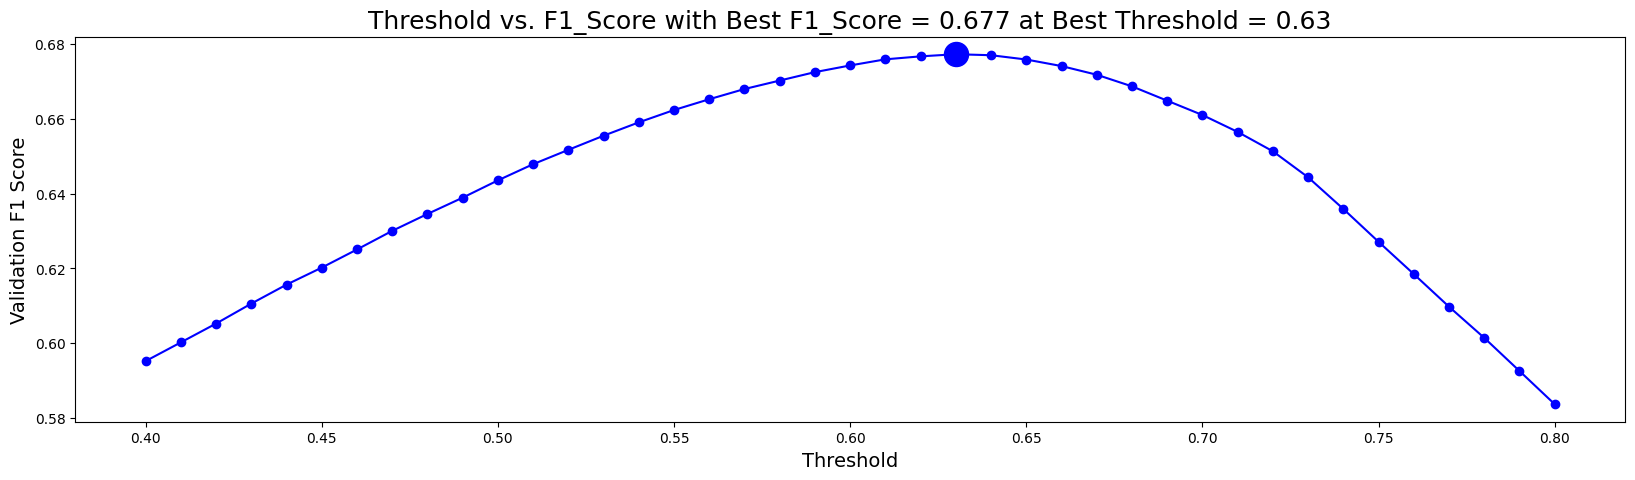

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [13]:
print('When using optimal threshold...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6181086769232517
Q1: F1 = 0.5069390313347237
Q2: F1 = 0.4961841294976687
Q3: F1 = 0.6168962161482003
Q4: F1 = 0.5696055197249379
Q5: F1 = 0.6057871531339933
Q6: F1 = 0.5840163918566937
Q7: F1 = 0.5419100065382676
Q8: F1 = 0.5991601821726419
Q9: F1 = 0.5058804398966766
Q10: F1 = 0.5857493921724746
Q11: F1 = 0.49722899650186175
Q12: F1 = 0.43464051140571763
Q13: F1 = 0.6006029163207067
Q14: F1 = 0.505043972741658
Q15: F1 = 0.4546437659834862
Q16: F1 = 0.5150041839383604
Q17: F1 = 0.49895326036985527
==> Overall F1 = 0.6771787367679476
